<a href="https://colab.research.google.com/github/BaishaliChetia/CapsNet-Keras/blob/master/capsFashionMnistipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow.keras as K
#import tensorflow_model_optimization as tfmot

In [2]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 8.9 MB/s 


In [3]:
import tensorflow_model_optimization as tfmot

In [4]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8
caps2_n_caps = 10
caps2_n_dims = 16

tf.random.set_seed(500000)

In [5]:
#class SquashLayer(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class SquashLayer(K.layers.Layer):
  def __init__(self, axis=-1, **kwargs):
    super(SquashLayer, self).__init__(**kwargs)
    self.axis = axis
    
  def build(self, input_shapes):
    pass

  """
  def get_prunable_weights(self):
    return []
  """

  def call(self, inputs):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def get_config(self):
    config = super(SquashLayer, self).get_config()
    config.update({"axis": self.axis})
    return config

 
#class SafeNorm(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class SafeNorm(K.layers.Layer):
  
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(SafeNorm, self).__init__(**kwargs)
    self.axis = axis
    self.keep_dims = keep_dims

  def build(self, input_shapes):
    pass

  """
  def get_prunable_weights(self):
    return []
  """

  def call(self, input):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims= self.keep_dims)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    return safe_norm

  def get_config(self):
    config = super(SafeNorm, self).get_config()
    config.update({"axis": self.axis, "keep_dims": self.keep_dims})
    return config
  
# This should be the part where the digit layer, and where we tile things
# This is incomplete, and work in progress
# TODO: Complete this
class MyDigitCapsLayer(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
  def __init__(self, **kwargs):
    super(MyDigitCapsLayer, self).__init__(**kwargs)
  
  def get_config(self):
    config =  super(MyDigitCapsLayer, self).get_config()
    return config
  

  def build(self, input_shapes):
    init_sigma = 0.1  # TODO: use
    self.kernel = self.add_weight(\
                      "kernel",\
                      (caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),\
                      initializer="random_normal",\
                      dtype=tf.float32)

  
  # To debug this function, I used prints to print the shape
  # expand_dims just adds an exis, so if you say expand_dims(inshape=(5, 3), -1),
  # you get the output shape (5, 3, 1), it just adds an axis at the end
  # Then tile just multiplies one of the dimensions (that is it stacks along that direction N times)
  # so tile(inshape=(5, 3, 1), [1, 1, 1000]) will yield a shape (5, 3, 1000)
  #
  # Notice I didn't tile in build, but in call, Most probaly this is the right thing to do
  # but we'll only figure out when we actually train
  def get_prunable_weights(self):
    return [self.kernel]
  
  def call(self, inputs):
    # Add a dimension at the end
    exp1 = tf.expand_dims(inputs, -1, name="caps1_output_expanded")
    # add a dimension along 3rd axis
    exp1 = tf.expand_dims(exp1, 2, name="caps2_output_espanced")
    # tile along 3rd axis
    tile = tf.tile(exp1, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled")
    caps2_predicted = tf.matmul(self.kernel, tile, name="caps2_predicted")
    return caps2_predicted

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss
class MarginLoss(K.losses.Loss):
    def __init__(self, **kwargs):
      super(MarginLoss, self).__init__(**kwargs)

  
    def get_config(self):
      config = super(MarginLoss, self).get_config()
      return config
    
    def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=False, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

    """
    def get_prunable_weights(self):
      return []
    """

    def call(self,y_true, input):
      # print(f"y_true.shape = {y_true.shape}, y_pred.shape = {y_pred.shape}")
      # return K.losses.MeanSquaredError()(y_true, y_pred)

      #y_true = K.Input(shape=[], dtype=tf.int64, name="y")
      m_plus = 0.9
      m_minus = 0.1
      lambda_ = 0.5 
      
      #y_true one hot encode y_train
      T = tf.one_hot(y_true, depth=caps2_n_caps, name="T")
      
      caps2_output_norm = self.safe_norm(input, keep_dims = True)

      present_error_raw = tf.square(\
                                    tf.maximum(0., m_plus - caps2_output_norm),
                                    name="present_error_raw")
      present_error = tf.reshape(\
                                    present_error_raw, shape=(-1, 10),
                                    name="present_error")  
  
      absent_error_raw = tf.square(\
                                    tf.maximum(0., caps2_output_norm - m_minus),
                                    name="absent_error_raw")
      absent_error = tf.reshape(\
                                    absent_error_raw, shape=(-1, 10),
                                    name="absent_error")
  
      L = tf.add(\
                  T * present_error,\
                  lambda_ * (1.0 - T) * absent_error,
                  name="L")
      marginLoss = tf.reduce_mean(\
                                  tf.reduce_sum(L, axis=1),\
                                  name="margin_loss")
      return marginLoss


#class RoutingByAgreement(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class RoutingByAgreement(K.layers.Layer):
  def __init__(self, round_number=-1, **kwargs):
    super(RoutingByAgreement, self).__init__(**kwargs)
    self.round_number = round_number 

  def get_config(self):
    config = super(RoutingByAgreement, self).get_config()
    config.update({"round_number": self.round_number})
    return config
 

  def build(self, input_shapes):
    self.raw_weights_1 = self.add_weight("raw_weights", \
                                         (caps1_n_caps, caps2_n_caps, 1, 1), \
                                         initializer = "zeros", \
                                         dtype=tf.float32,)
    
    #print("Routing layer: self.raw_weights = ", self.raw_weights.shape, "input_shape = ", input_shapes)

  
  def get_prunable_weights(self):
    return [self.raw_weights_1]


  @staticmethod
  def squash(inputs):
    EPSILON = 1.0e-5
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def single_round_routing(self, inputs, raw_weights, agreement):
    raw_weights = tf.add(raw_weights, agreement)
    routing_wt = tf.nn.softmax(raw_weights, axis=2)
    wt_predictions = tf.multiply(routing_wt, inputs)
    wt_sum = tf.reduce_sum(wt_predictions, axis=1, keepdims=True)
    return wt_sum

  def call(self, inputs):
    agreement = tf.zeros(shape=self.raw_weights_1.shape)
    sqsh_wt_sum = None
    x = inputs
    for i in range(2):
      wt_sum = self.single_round_routing(inputs, self.raw_weights_1, agreement)
      sqsh_wt_sum = RoutingByAgreement.squash(wt_sum)
      sqsh_wt_sum_tiled = tf.tile(\
                          sqsh_wt_sum ,\
                          [1, caps1_n_caps, 1, 1, 1],\
                          name="caps2_output_round_1_tiled")
      agreement = tf.matmul(\
                            x, \
                            sqsh_wt_sum_tiled,\
                            transpose_a=True,\
                            name="agreement")
    return sqsh_wt_sum

class MyAccuracy(K.metrics.Metric):
  def __init__(self, **kwargs):
    super(MyAccuracy, self).__init__(**kwargs)
    self.acc_obj = K.metrics.Accuracy()
    self.state = 0
  

  def get_config(self):
    config = super(MyAccuracy, self).get_config()
    config.update({"acc_obj": None, "state": self.state})
    return config
  

  def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def update_state(self, y_true, input, sample_weight=None):
    if self.acc_obj is None:
      self.acc_obj = K.metrics.Accuracy()
    y_proba = self.safe_norm(input, axis=-2)
    y_proba_argmax = tf.argmax(y_proba, axis=2)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    #y_true = tf.reshape(y_true, (y_true.shape[0], ))
    y_true = tf.cast(y_true, dtype=tf.int64)
    self.acc_obj.update_state(y_true, y_pred, sample_weight)

  def reset_state(self):
    self.acc_obj.reset_state()

  def result(self):
    return self.acc_obj.result()

class MyReshapeLayer(K.layers.Layer):
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(MyReshapeLayer, self).__init__(**kwargs)

  def build(self, input_shapes):
    pass

  def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def call(self, input):
    print('printing shapes ------------------- ')
    EPSILON = 1.0e-9
    print(input)
    y_proba = self.safe_norm(input, axis=-2)
    print(y_proba)
    y_proba_argmax = tf.argmax(y_proba, axis=2)
    print(y_proba_argmax)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    print(y_pred)
    return tf.cast(y_pred, tf.int64)

  def get_config(self):
    config = super(MyReshapeLayer, self).get_config()
    return config
  

In [6]:
(x_train, y_train,), (x_test, y_test) = K.datasets.fashion_mnist.load_data()
#print(x_train.shape, x_test.shape)
x_train = x_train/255.0
x_test = x_test/255.0

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
class Model:
    @staticmethod
    def build(inshape=(28, 28, 1)):
        inp = K.Input(shape=inshape, dtype=tf.float32, name='input')
        
        # Primary capsules
        # For each digit in the batch
        # 32 maps, each 6x6 grid of 8 dimensional vectors
        
        # First Conv layer
        conv1_params = \
        {
            "filters": 256,
            "kernel_size": 9,
            "strides": 1,
            "padding": "valid",
            "activation": tf.nn.relu,
        }
        x = K.layers.Conv2D(**conv1_params, name="conv_layer_1")(inp)
        
        # Second conv layer
        conv2_params = \
        {
            "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
            "kernel_size": 9,
            "strides": 2,
            "padding": "valid",
            "activation": tf.nn.relu
        }
        x = K.layers.Conv2D(**conv2_params, name="conv_layer_2")(x)
        
        # Reshape
        x = K.layers.Reshape(\
                             (caps1_n_caps, caps1_n_dims),\
                             name="reshape_layer_1")(x)
                             
        x = SquashLayer(name="caps1_output_layer")(x)
        
        x = MyDigitCapsLayer(name = "caps2_predicted")(x)
        caps2_predicted = x # Save this value for later
        
        #routing by agreement (2 rounds)
        x = RoutingByAgreement(name="routing1", round_number=2)(x)
        
        return K.Model(inputs=inp, outputs=x, name='my_model')
    
m = Model.build()
print(m.summary())


Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1152, 8)           0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1152, 8)           0         
_________________________________________________________________
caps2_predicted (MyDigitCaps (None, 1152, 10, 16, 1)   1474560   
_________________________________________________________________
routing1 (RoutingByAgreement (None, 1, 10, 16, 1)      115

In [9]:
from keras.callbacks import ModelCheckpoint, CSVLogger
comparison_metric = MyAccuracy()
#checkpoint_filepath = "/content/drive/MyDrive/Weights/weights-improvement-{epoch:02d}-{val_my_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/FashionMnistResults/best_weights1.hdf5",
        save_weights_only=True,
        #monitor=f"val_{comparison_metric.name}",
        monitor="val_my_accuracy",
        mode='max',
        save_best_only=True)
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/FashionMnistResults/latest_weights1.hdf5",
        save_weights_only=True,
        monitor=f"val_{comparison_metric.name}",
        mode='max',
        save_best_only=False)
log_csv = CSVLogger("/content/drive/MyDrive/FashionMnistResults/mylogs1.csv", separator = ",", append = False)
callback_list = [model_checkpoint_callback, model_checkpoint_callback2, log_csv]

In [10]:
m.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
history = m.fit(x_train, y_train, batch_size=32, epochs=70, verbose= 1, validation_split=0.2, callbacks = callback_list)


Epoch 1/70
1500/1500 [==============================] - 169s 101ms/step - loss: 2.2815 - my_accuracy_2: 0.1503 - val_loss: 2.2805 - val_my_accuracy_2: 0.3329
Epoch 2/70
1500/1500 [==============================] - 147s 98ms/step - loss: 2.2801 - my_accuracy_2: 0.3174 - val_loss: 2.2800 - val_my_accuracy_2: 0.2937
Epoch 3/70
1500/1500 [==============================] - 140s 93ms/step - loss: 2.2799 - my_accuracy_2: 0.4529 - val_loss: 2.2795 - val_my_accuracy_2: 0.5285
Epoch 4/70
1500/1500 [==============================] - 139s 92ms/step - loss: 2.2796 - my_accuracy_2: 0.5811 - val_loss: 2.2795 - val_my_accuracy_2: 0.6157
Epoch 5/70
1500/1500 [==============================] - 146s 98ms/step - loss: 2.2795 - my_accuracy_2: 0.6249 - val_loss: 2.2792 - val_my_accuracy_2: 0.6752
Epoch 6/70
1500/1500 [==============================] - 144s 96ms/step - loss: 2.2794 - my_accuracy_2: 0.6521 - val_loss: 2.2798 - val_my_accuracy_2: 0.5907
Epoch 7/70
1500/1500 [==============================] - 1

In [12]:
print(f'Best Validation Accuracy = {np.max(history.history["val_my_accuracy_2"])}')
print(f'Best Training   Accuracy = {np.max(history.history["my_accuracy_2"])}')

Best Validation Accuracy = 0.8742499947547913
Best Training   Accuracy = 0.8719375133514404


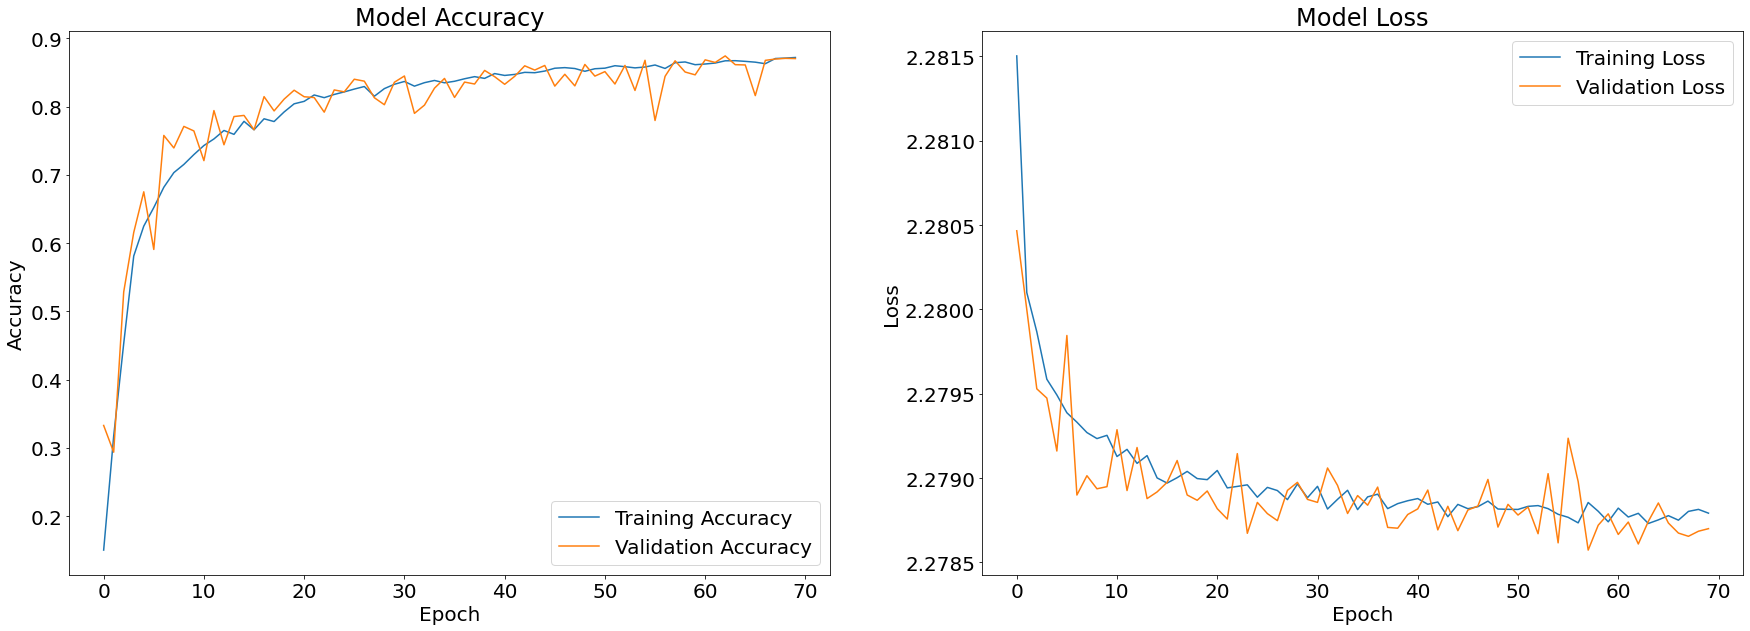

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['my_accuracy_2'])
ax[0].plot(history.history['val_my_accuracy_2'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()